#INSTALAR TORCH-GEOMETRIC

In [6]:
!pip install torch-geometric

#Preparar Data de Experimento

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [8]:
data = "ratings_Electronics (1).csv"
df = pd.read_csv(data)
df.head()

,AKM1MP6P0OYPR,0132793040,5.0,1365811200
0,A2CX7LUOHB2NDG,0321732944,5.0,1.341101e+09
1,A2NWSAGRHCP8N5,0439886341,1.0,1.367194e+09
2,A2WNBOD3WNDNKT,0439886341,3.0,1.374451e+09
3,A1GI0U4ZRJA8WN,0439886341,1.0,1.334707e+09
4,A1QGNMC6O1VW39,0511189877,5.0,1.397434e+09


In [9]:
#Renombrar Headers y recodear IDs
df.rename(columns = {'AKM1MP6P0OYPR':'usuarioID', '0132793040':'productID', '5.0':'Rating', '1365811200':'timestamp'}, inplace = True)

#Recortar data a 5k entradas
ds = df.head(5000)

# Limpiar data
ds.dropna(inplace=True)
ds.drop_duplicates(inplace=True)

# Encode user IDs and item IDs
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

ds['usuarioID'] = user_encoder.fit_transform(ds['usuarioID'])
ds['productID'] = item_encoder.fit_transform(ds['productID'])

# Sets de entrenamiento, validacion y test
train_df, test_df = train_test_split(ds, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Display the shape of the datasets
train_df.shape, val_df.shape, test_df.shape
ds.head()

<ipython-input-9-daf55cda226e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds.dropna(inplace=True)
<ipython-input-9-daf55cda226e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds.drop_duplicates(inplace=True)
<ipython-input-9-daf55cda226e>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds['usuarioID'] = user_encoder.fit_transform(ds['usuarioID'])
<ipython-input-9-daf55

,usuarioID,productID,Rating,timestamp
0,1759,0,5.0,1.341101e+09
1,2154,1,1.0,1.367194e+09
2,2477,1,3.0,1.374451e+09
3,603,1,1.0,1.334707e+09
4,960,2,5.0,1.397434e+09


In [10]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   usuarioID  5000 non-null   int64  
 1   productID  5000 non-null   int64  
 2   Rating     5000 non-null   float64
 3   timestamp  5000 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 156.4 KB


In [11]:
ds.to_csv('processed_data.csv')

#Creación del Grafo

In [12]:
# Crear vértices de las interacciones usuario-producto
edge_index = torch.tensor([train_df['usuarioID'].values, train_df['productID'].values], dtype=torch.long)

# Crear atributos de los vértices (ratings)
edge_attr = torch.tensor(train_df['Rating'].values, dtype=torch.float)

# Crear PyTorch Geometric data object
data = Data(edge_index=edge_index, edge_attr=edge_attr)

data

<ipython-input-12-c9f1bcc9365d>:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  edge_index = torch.tensor([train_df['usuarioID'].values, train_df['productID'].values], dtype=torch.long)


Data(edge_index=[2, 3200], edge_attr=[3200])

In [13]:
num_usuarios = ds['usuarioID'].nunique()
num_items = ds['productID'].nunique()
num_nodos = num_usuarios + num_items

# Crear características de los nodos
node_features = torch.eye(num_nodos)

# Agregar las características de los nodos
data.x = node_features

# Mostrar data object actualizado
data

Data(edge_index=[2, 3200], edge_attr=[3200], x=[5227, 5227])

#Modelo

In [14]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.fc = torch.nn.Linear(hidden_channels * 2, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        # Se aplica una capa lineal a las características de cada nodo
        edge_pred = self.fc(torch.cat([x[edge_index[0]], x[edge_index[1]]], dim=1))
        return edge_pred.squeeze()

# Inicializar modelo
model = GCN(in_channels=node_features.size(1), hidden_channels=16, out_channels=1)

print(model)

GCN(
  (conv1): GCNConv(5227, 16)
  (conv2): GCNConv(16, 16)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [15]:
# Data loader
train_loader = DataLoader([data], batch_size=1, shuffle=True)

# Optimizador y Función de Pérdida
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
for epoch in range(200):
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch.edge_attr.view(-1, 1))
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch + 1}, Loss: {loss.item()}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3200, 1])) that is different to the input size (torch.Size([3200])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Loss: 17.538991928100586
Epoch 2, Loss: 16.727317810058594
Epoch 3, Loss: 15.681811332702637
Epoch 4, Loss: 14.336017608642578
Epoch 5, Loss: 12.7503023147583
Epoch 6, Loss: 11.017950057983398
Epoch 7, Loss: 9.2426176071167
Epoch 8, Loss: 7.596254825592041
Epoch 9, Loss: 6.336594581604004
Epoch 10, Loss: 5.743646621704102
Epoch 11, Loss: 5.884809494018555
Epoch 12, Loss: 6.311532020568848
Epoch 13, Loss: 6.339272975921631
Epoch 14, Loss: 5.850867748260498
Epoch 15, Loss: 5.177742004394531
Epoch 16, Loss: 4.383989334106445
Epoch 17, Loss: 3.746782064437866
Epoch 18, Loss: 3.3369202613830566
Epoch 19, Loss: 3.1188948154449463
Epoch 20, Loss: 3.004969835281372
Epoch 21, Loss: 2.909014940261841
Epoch 22, Loss: 2.79965877532959
Epoch 23, Loss: 2.677860736846924
Epoch 24, Loss: 2.586881399154663
Epoch 25, Loss: 2.569578170776367
Epoch 26, Loss: 2.5569067001342773
Epoch 27, Loss: 2.4761712551116943
Epoch 28, Loss: 2.39569091796875
Epoch 29, Loss: 2.3515944480895996
Epoch 30, Loss: 2.

##Guardar Modelo

In [16]:
torch.save(model.state_dict(), "GCN.pt")

#Evaluar Modelo

In [17]:
# Convertir sets de validacion y test data a formato PyTorch Geometric
val_edge_index = torch.tensor([val_df['usuarioID'].values, val_df['productID'].values], dtype=torch.long)
val_edge_attr = torch.tensor(val_df['Rating'].values, dtype=torch.float)

test_edge_index = torch.tensor([test_df['usuarioID'].values, test_df['productID'].values], dtype=torch.long)
test_edge_attr = torch.tensor(test_df['Rating'].values, dtype=torch.float)

# Data objects para sets de validacion y test
val_data = Data(edge_index=val_edge_index, edge_attr=val_edge_attr, x=node_features)
test_data = Data(edge_index=test_edge_index, edge_attr=test_edge_attr, x=node_features)

# Evaluar modelo
model.eval()
with torch.no_grad():
    val_out = model(val_data)
    test_out = model(test_data)

# Métricas
val_rmse = mean_squared_error(val_edge_attr.numpy(), val_out.numpy(), squared=False)
val_mae = mean_absolute_error(val_edge_attr.numpy(), val_out.numpy())

test_rmse = mean_squared_error(test_edge_attr.numpy(), test_out.numpy(), squared=False)
test_mae = mean_absolute_error(test_edge_attr.numpy(), test_out.numpy())

print(f'Validation RMSE: {val_rmse}, Validation MAE: {val_mae}')
print(f'Test RMSE: {test_rmse}, Test MAE: {test_mae}')


Validation RMSE: 1.5436961650848389, Validation MAE: 1.3739646673202515
Test RMSE: 1.5115487575531006, Test MAE: 1.3281872272491455


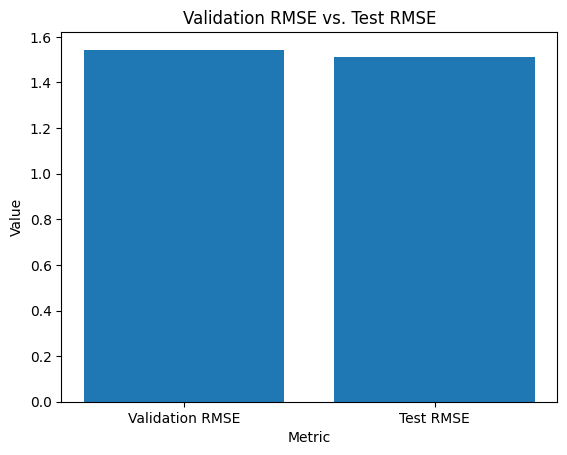

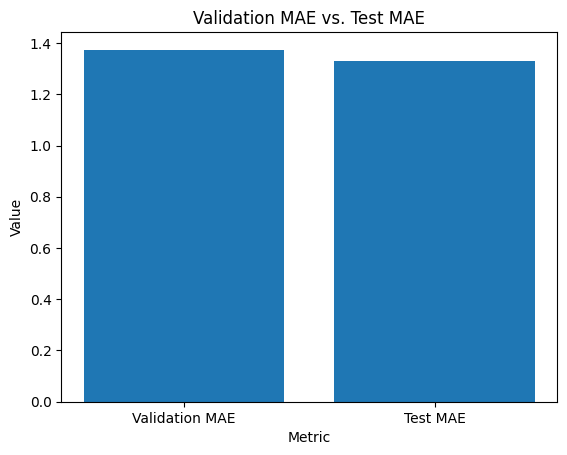

In [18]:
import matplotlib.pyplot as plt
# Prepare data for the plot
labels_rmse = ['Validation RMSE', 'Test RMSE']
values_rmse = [val_rmse, test_rmse]

labels_mae = ['Validation MAE', 'Test MAE']
values_mae = [val_mae, test_mae]

# Create the bar chart for RMSE
plt.bar(labels_rmse, values_rmse)
plt.title('Validation RMSE vs. Test RMSE')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.show()

# Create the bar chart for MAE
plt.bar(labels_mae, values_mae)
plt.title('Validation MAE vs. Test MAE')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.show()

#Obtener Recomendaciones

In [19]:
# Seleccionar ID de Usuario
user_id = 5154

# Obtener indices de products con los que el usuario no interactuó aún
uninteracted_items = torch.tensor([i for i in range(num_items) if i not in train_df.productID.values])

# Data object de productos no interactuados
user_data = Data(edge_index=torch.tensor([[user_id] * len(uninteracted_items), uninteracted_items]), x=node_features)

# Predecir ratings de productos no interactuados
model.eval()
with torch.no_grad():
    predictions = model(user_data)

# Ordenar predicciones de forma descendente
_, sorted_indices = torch.sort(predictions, descending=True)

# Obtener Top 10 recomendaciones
k = 10
recommended_items = uninteracted_items[sorted_indices[:k]]

# Print the recommended items
print(f"Productos recomendados al usuario con ID {user_id}: {recommended_items}")

Productos recomendados al usuario con ID 5154: tensor([ 67, 236, 225, 130, 149, 251,  22,   0, 210, 277])


In [20]:
#resultados en un csv

recommendations_df = pd.DataFrame(recommended_items, columns=['productID'])
recommendations_df['usuarioID'] = user_id
recommendations_df.to_csv('recommendations.csv', index=False)